### The below algorithm is used to classify whether a new image being tested is from one of the following categories. [Faucet, Hammer, Flowerpot, Thermostat]

#### Import all necessary packages

In [96]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image



import  numpy as np

import os, sys, json
import numpy as np
#import utils; reload(utils)
#from utils import plots
%matplotlib inline

#import modules
#from utils import *
#from vgg16 import Vgg16

from sklearn.preprocessing import LabelBinarizer
from random import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from IPython.display import Image 

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline


In [97]:
#Create references to important directories we will use over and over

current_dir = os.getcwd()
MAIN_HOME_DIR = '/Users/jac812i/Documents/Imagerecognition'
DATA_HOME_DIR = '/Users/jac812i/Documents/Imagerecognition'
#print(MAIN_HOME_DIR)

### Action Plan
####    1) Create Training, Validation and Test sets
####    2) Rearrange image files into their respective directories
####    3) Finetune and Train model
####    4) Generate predictions on Test Data
####    5) Model Evaluation on Test Data


### Create Training, Validation and test folders and data sets.

In [98]:
#Create directories in the above mentioned format
%cd $DATA_HOME_DIR
%mkdir train
%mkdir valid
%mkdir test
%mkdir results
%cd $DATA_HOME_DIR/train
%ls $DATA_HOME_DIR/train
%ls $DATA_HOME_DIR/valid


/Users/jac812i/Documents/Imagerecognition
mkdir: train: File exists
mkdir: valid: File exists
mkdir: test: File exists
mkdir: results: File exists
/Users/jac812i/Documents/Imagerecognition/train
faucet/      flowerpots/  hammer/      thermostats/
faucet/      flowerpots/  hammer/      thermostats/


In [69]:

#Only run this during the first time
#Count the number of imnages for faucet category
%cd $DATA_HOME_DIR/train/faucet
%ls -1 | wc -l
#move twenty percent of data from training to validation data
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(18): os.rename(shuf[i], DATA_HOME_DIR+'/valid/faucet' + shuf[i])
%ls -1 | wc -l
"""

"\n#Only run this during the first time\n#Count the number of imnages for faucet category\n%cd $DATA_HOME_DIR/train/faucet\n%ls -1 | wc -l\n#move twenty percent of data from training to validation data\ng = glob('*.jpg')\nshuf = np.random.permutation(g)\nfor i in range(18): os.rename(shuf[i], DATA_HOME_DIR+'/valid/faucet' + shuf[i])\n%ls -1 | wc -l\n"

In [70]:

#Only run this during the first time
#Count the number of imnages for flowerpots category
%cd $DATA_HOME_DIR/train/flowerpots
%ls -1 | wc -l
#move twenty percent of data from training to validation data
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(11): os.rename(shuf[i], DATA_HOME_DIR+'/valid/flowerpots' + shuf[i])
%ls -1 | wc -l
"""

"\n#Only run this during the first time\n#Count the number of imnages for flowerpots category\n%cd $DATA_HOME_DIR/train/flowerpots\n%ls -1 | wc -l\n#move twenty percent of data from training to validation data\ng = glob('*.jpg')\nshuf = np.random.permutation(g)\nfor i in range(11): os.rename(shuf[i], DATA_HOME_DIR+'/valid/flowerpots' + shuf[i])\n%ls -1 | wc -l\n"

In [71]:

#Only run this during the first time
#Count the number of imnages for hammers category
%cd $DATA_HOME_DIR/train/hammer
%ls -1 | wc -l
#move twenty percent of data from training to validation data
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(14): os.rename(shuf[i], DATA_HOME_DIR+'/valid/hammer' + shuf[i])
%ls -1 | wc -l


"\n#Only run this during the first time\n#Count the number of imnages for hammers category\n%cd $DATA_HOME_DIR/train/hammer\n%ls -1 | wc -l\n#move twenty percent of data from training to validation data\ng = glob('*.jpg')\nshuf = np.random.permutation(g)\nfor i in range(14): os.rename(shuf[i], DATA_HOME_DIR+'/valid/hammer' + shuf[i])\n%ls -1 | wc -l\n"

In [72]:

#Only run this during the first time
#Count the number of imnages for thermostats category
%cd $DATA_HOME_DIR/train/thermostats
%ls -1 | wc -l
#move twenty percent of data from training to validation data
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(19): os.rename(shuf[i], DATA_HOME_DIR+'/valid/thermostats' + shuf[i])
%ls -1 | wc -l



"\n#Only run this during the first time\n#Count the number of imnages for thermostats category\n%cd $DATA_HOME_DIR/train/thermostats\n%ls -1 | wc -l\n#move twenty percent of data from training to validation data\ng = glob('*.jpg')\nshuf = np.random.permutation(g)\nfor i in range(19): os.rename(shuf[i], DATA_HOME_DIR+'/valid/thermostats' + shuf[i])\n%ls -1 | wc -l\n\n"

In [99]:
%cd $DATA_HOME_DIR/valid
%mv the*.jpg thermostats/
%mv hamm*.jpg hammer/
%mv fauc*.jpg faucet/
%mv flo*.jpg flowerpots/


/Users/jac812i/Documents/Imagerecognition/valid
mv: rename the*.jpg to thermostats/the*.jpg: No such file or directory
mv: rename hamm*.jpg to hammer/hamm*.jpg: No such file or directory
mv: rename fauc*.jpg to faucet/fauc*.jpg: No such file or directory
mv: rename flo*.jpg to flowerpots/flo*.jpg: No such file or directory


In [100]:
#DATA_HOME_DIR + '/valid/the*.jpg'

### Creating and Training the model

In [101]:
%cd $DATA_HOME_DIR

#Set appropriate paths
path = DATA_HOME_DIR + '/' #'/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + 'train/'
valid_path=path + 'valid/'

/Users/jac812i/Documents/Imagerecognition


In [102]:
#% ls -l /Users/jac812i/Documents/Imagerecognition/valid/

In [103]:
#Preprocess the image
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    #x = x - vgg_mean
    x = x - np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    return x[:, ::-1] # reverse axis rgb->bgr

In [104]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [105]:
#Implementing vgg16 model.

model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))


model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))


model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))


model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='softmax'))





/anaconda/anaconda/envs/keraslearn/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/anaconda/anaconda/envs/keraslearn/lib/python2.7/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/anaconda/anaconda/envs/keraslearn/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  
/anaconda/anaconda/envs/keraslearn/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  app.launch_new_instance()
/anaconda/anaconda/envs/keraslearn/lib/python2.7/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256

In [106]:
#model.summary()

In [107]:
# Test pretrained model
#model = VGG_16('/Users/jac812i/Documents/fastai/courses/deeplearning1/nbs/vgg16.h5')

model.load_weights('/Users/jac812i/Documents/fastai/courses/deeplearning1/nbs/vgg16.h5')


In [108]:
#Remove the last dense layer since in our scenario we have only 4 labels
model.pop()

In [109]:
#Make the layers in the model not trainable
for layers in model.layers : layers.trainable = False

In [110]:
#view the model
#model.summary()

In [111]:
#Add the dense model with output 4 labels
model.add(Dense(4, activation='softmax'))

In [112]:
#view model
#model.summary()

In [113]:
# compile the model
model.compile(optimizer=Adam(lr=0.0001),
                loss='categorical_crossentropy', metrics=['accuracy'])

In [114]:
#set the image data generator for train, valid and test
train_datagen = image.ImageDataGenerator()
#train_datagen = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
#                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
validation_datagen = image.ImageDataGenerator()
test_datagen = image.ImageDataGenerator()

In [115]:
#Set the batch size s input to flow_from_directory
batch_size = 10

In [116]:
# Pass the training data to train_generator

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 244 images belonging to 4 classes.


In [117]:
# Pass the validation data to validation_generator
validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 62 images belonging to 4 classes.


In [43]:
# Fit the model
model.fit_generator(train_generator, samples_per_epoch=244, nb_epoch=10,
                    validation_data=validation_generator, nb_val_samples=62)

/anaconda/anaconda/envs/keraslearn/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=24, epochs=10, validation_steps=62)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/10
24/24 [==============================] - 232s - loss: 2.2936 - acc: 0.3625 - val_loss: 0.6035 - val_acc: 0.8381
Epoch 2/10
24/24 [==============================] - 221s - loss: 1.1571 - acc: 0.6418 - val_loss: 0.2849 - val_acc: 0.9343
Epoch 3/10
24/24 [==============================] - 220s - loss: 0.6686 - acc: 0.7688 - val_loss: 0.1615 - val_acc: 0.9690
Epoch 4/10
24/24 [==============================] - 225s - loss: 0.4327 - acc: 0.8605 - val_loss: 0.1157 - val_acc: 0.9690
Epoch 5/10
24/24 [==============================] - 229s - loss: 0.3777 - acc: 0.8981 - val_loss: 0.0849 - val_acc: 0.9836
Epoch 6/10
24/24 [==============================] - 225s - loss: 0.3395 - acc: 0.8897 - val_loss: 0.0648 - val_acc: 1.0000
Epoch 7/10
24/24 [==============================] - 222s - loss: 0.2321 - acc: 0.9458 - val_loss: 0.0538 - val_acc: 1.0000
Epoch 8/10
24/24 [==============================] - 220s - loss: 0.1768 - acc: 0.9231 - val_loss: 0.0484 - val_acc: 1.0000
Epoch 9/10
24/24

In [97]:
#save the weights so that we can reuse it later instead of fitting the model again.
results_path=DATA_HOME_DIR + '/results/'
model.save_weights(results_path + 'vgg16tunedmodelweights.h5')


In [119]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
img_path = '/Users/jac812i/Documents/Imagerecognition/unknown/unknown/images?q=tbn:ANd9GcSTraBoazT_Rk9-BRdntEDaDvE2QWd2wimQuoZg4Ho-h9eFbliH.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
new_image=np.array(x).reshape((3,224,224))
new_image = np.expand_dims(new_image, axis=0)
preds = model.predict(new_image)

print (preds)



[[  8.58664862e-05   9.99517262e-01   2.04713087e-05   3.76427895e-04]]


In [120]:
unknown_predictions_1 = model.predict(new_image, batch_size=1, verbose=0)
#model prediction
pred_1 = dict(zip(labels, unknown_predictions_1[0]))
bestpred_1 = labels[np.argmax(unknown_predictions_1[0])]
print ("probabilties for each category", pred_1)
print ("Model predicted image is ", bestpred_1)

('probabilties for each category', {'faucet': 8.5866486e-05, 'hammer': 2.0471309e-05, 'thermostats': 0.0003764279, 'flowerpots': 0.99951726})
('Model predicted image is ', 'flowerpots')


In [44]:
#model.summary()

In [122]:
results_path=DATA_HOME_DIR + '/results/'
#Load the saved weights
model.load_weights(results_path + 'vgg16tunedmodelweights.h5')

In [123]:
# predict model accuracy on validation data set
scores = model.evaluate_generator(validation_generator,62) #1514 testing images
print("Accuracy = ", scores[1])

('Accuracy = ', 0.96762589349163519)


In [48]:

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(test_path + filenames[i]) for i in idx], titles=titles)
    

# Predicting on Test Data

In [49]:
#Pass the test data to test_generator

test_path = DATA_HOME_DIR + '/test/'

test_generator = test_datagen.flow_from_directory(
    test_path,
    shuffle=False,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None)

Found 60 images belonging to 4 classes.


In [50]:
#get the filenames of test data
filenames = test_generator.filenames
#get the actual expected classes for test data
expected_labels = test_generator.classes
#get the predicted classes for test data
our_predictions = model.predict_generator(test_generator, len(test_generator.filenames))

In [51]:
#print len(filenames)
#print len(expected_labels)
#print len(our_predictions)
#print len(log_loss_labels)

In [52]:
#print (log_loss_labels)

In [53]:
#print expected_labels

In [54]:
# One hot function to encode the actual expected_labels
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # : Implement Function
    lb = LabelBinarizer()
    lb.fit(x)
    lb.classes_ = [0, 1, 2, 3]
    #print(lb.classes_)
    return lb.transform(x)

expected_labels_onehot = one_hot_encode(expected_labels)

In [55]:
#print expected_labels_onehot

In [56]:
#print our_predictions

In [57]:
#print len(our_predictions)

In [58]:
#Round the lables so that probability is converted to appropriate labels
our_labels = np.round(our_predictions)
#print our_labels

In [59]:
#Get correct prediction count based on expected_labels and our_labels
correctprediction = np.sum(np.all(np.equal(expected_labels_onehot, our_labels), axis=1))
print correctprediction

58


In [60]:
#Get false prediction count based on expected_labels and our_labels
falseprediction = len(expected_labels_onehot) - correctprediction
print falseprediction

2


In [61]:
#create a list of if expected labels and our_labels matched or not.
correct = np.all(np.equal(expected_labels_onehot, our_labels), axis=1)

In [62]:
#print (correct)

In [63]:
#Creating correct indices and false indices list
correct_index = []
false_index = []
i=0;
for value in correct:
    if value == True:
        correct_index.append(i)
    else:
        false_index.append(i)
    i = i + 1;


In [64]:
#print (correct_index)

In [65]:
#Shuffle the index
shuffle(correct_index)
#print correct_index


In [66]:
#print correct_index[54]

In [67]:
#Shuffle the index
shuffle(false_index)
#print false_index

In [77]:
from matplotlib.pyplot import *
import matplotlib.pyplot as plt


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

### Below is list of all True Predictions on Test Data downloaded from Google displayed 5 in each cell.

labels = ["faucet","flowerpots","hammer","thermostats"]


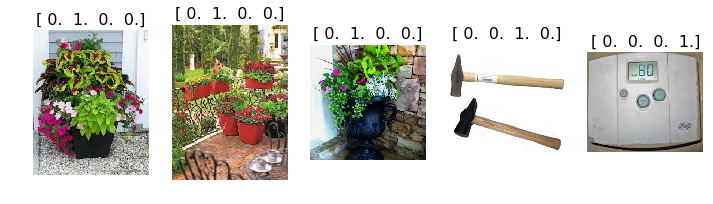

In [78]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[:5]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


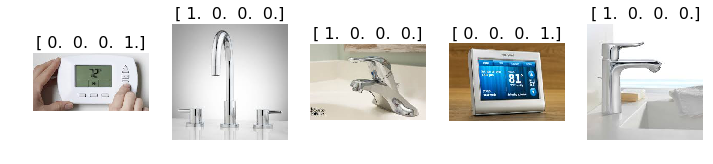

In [79]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[5:10]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


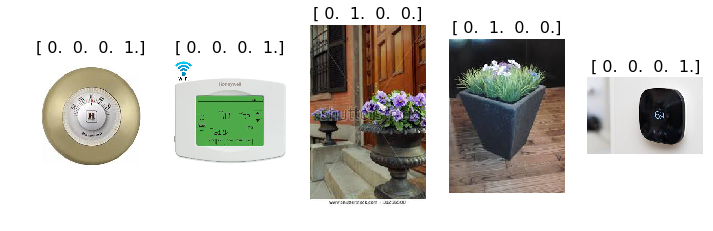

In [80]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[10:15]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


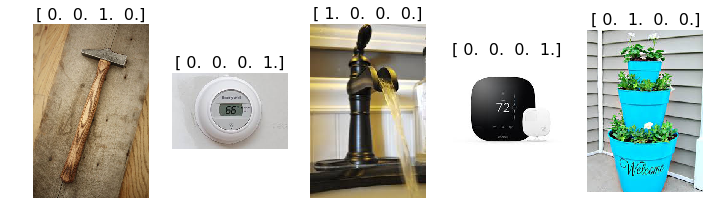

In [81]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[15:20]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


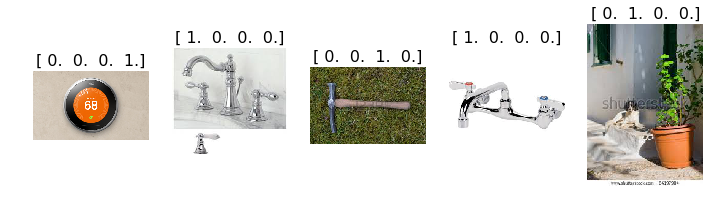

In [82]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[20:25]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


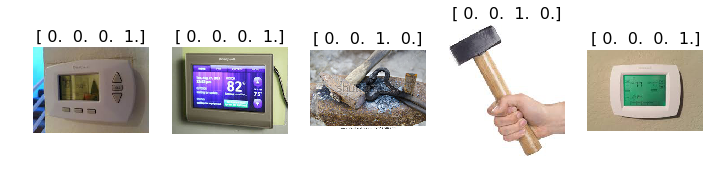

In [83]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[25:30]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


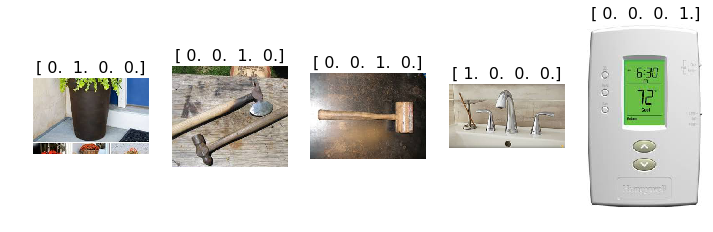

In [84]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[30:35]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


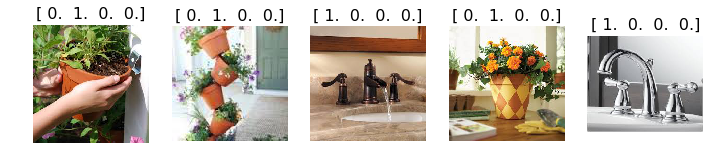

In [85]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[35:40]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


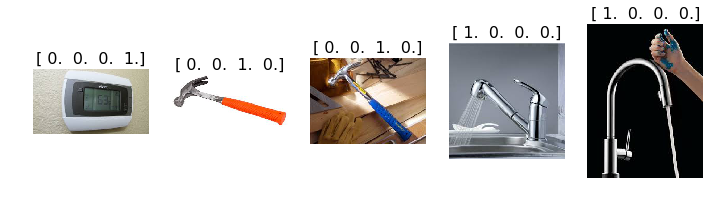

In [86]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[40:45]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


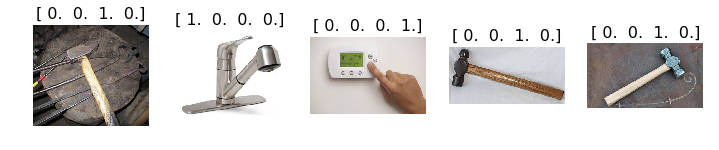

In [87]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[45:50]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


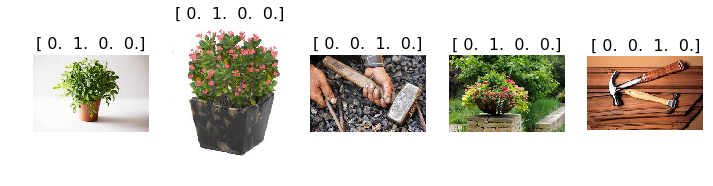

In [88]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[50:55]
plots_idx(idx, np.round(our_predictions[idx]))

labels = ["faucet","flowerpots","hammer","thermostats"]


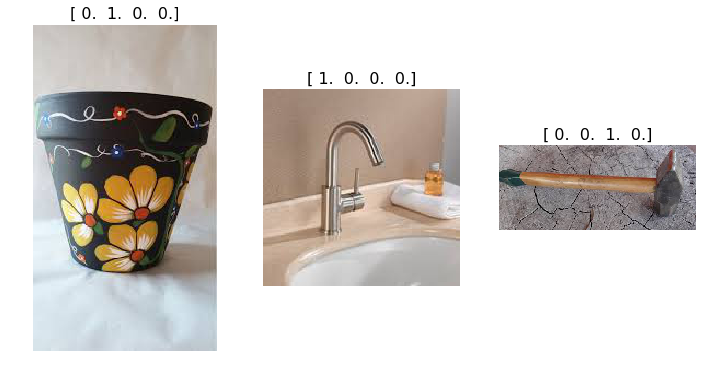

In [89]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = correct_index[55:60]
plots_idx(idx, np.round(our_predictions[idx]))

## Failed Predictions on Test Data downloaded from Google

labels = ["faucet","flowerpots","hammer","thermostats"]


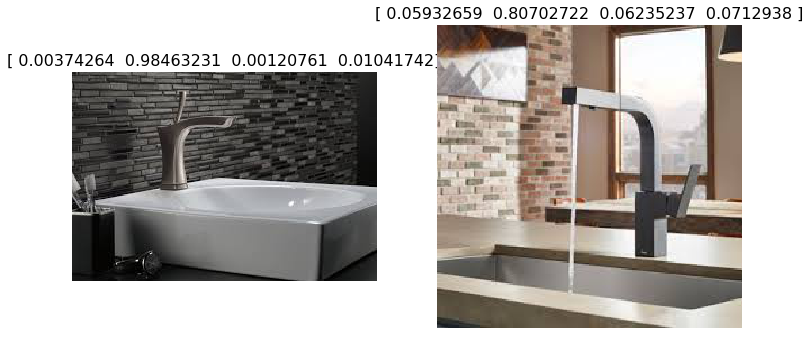

In [90]:
print ("labels = [\"faucet\",\"flowerpots\",\"hammer\",\"thermostats\"]")
idx = false_index[:4]
plots_idx(idx, our_predictions[idx])

## Evaluation metrics - Accuracy

In [91]:
#Use accuracy_score to calculate accuracy of the model
print accuracy_score(expected_labels_onehot, our_labels)

0.966666666667


## Evaluation metrics - Log Loss

In [92]:
#Use log_loss to calculate log loss of the model. The lower the log loss the better.
log_loss(our_labels, expected_labels_onehot, eps=1e-15)

1.1512925464970249

In [124]:
#save the model
from keras.models import load_model

model.save(results_path + 'image_recongition_model.h5')  # creates a HDF5 file 'my_model.h5'


In [125]:
#from keras.models import load_model
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model(results_path + 'image_recongition_model.h5')



### Checking probabilties of a sample image

In [126]:
# Create unknown directory and unknown class folder and then put an image in that so that you can predict the image category


unknown_datagen = image.ImageDataGenerator()

unknown_path = DATA_HOME_DIR + '/unknown/'

unknown_generator = unknown_datagen.flow_from_directory(
    unknown_path,
    shuffle=False,
    target_size=(224, 224),
    batch_size=1,
    class_mode=None)

Found 1 images belonging to 1 classes.


In [127]:
#Concatenate file names for test data and their appropriate probabilites
filenames = unknown_generator.filenames
filenames = np.array(filenames)
#imagepredictvalue = np.column_stack((filenames,our_predictions))
#print imagepredictvalue

In [128]:
#Labels as per folder structure
labels = ["faucet","flowerpots","hammer","thermostats"]

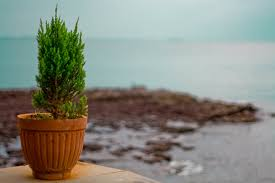

In [129]:
#Sample image to show the probabilites and what the model predicted
Image(filename=unknown_path + filenames[0])


In [130]:
#Predicting the image category
unknown_predictions = model.predict_generator(unknown_generator, len(unknown_generator.filenames))

In [131]:
#model prediction
pred = dict(zip(labels, unknown_predictions[0]))
bestpred = labels[np.argmax(unknown_predictions[0])]
print ("probabilties for each category", pred)
print ("Model predicted image is ", bestpred)

('probabilties for each category', {'faucet': 8.5866486e-05, 'hammer': 2.0471309e-05, 'thermostats': 0.0003764279, 'flowerpots': 0.99951726})
('Model predicted image is ', 'flowerpots')


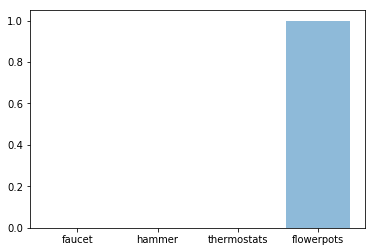

In [132]:
#Graph of model prediction probabilty for the above image
import matplotlib.pyplot as plt
plt.bar(range(len(pred)), pred.values(), align='center', alpha=0.5)
plt.xticks(range(len(pred)), list(pred.keys()))
plt.show()

In [133]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
img_path = '/Users/jac812i/Documents/Imagerecognition/unknown/unknown/images?q=tbn:ANd9GcSTraBoazT_Rk9-BRdntEDaDvE2QWd2wimQuoZg4Ho-h9eFbliH.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
new_image=np.array(x).reshape((3,224,224))
new_image = np.expand_dims(new_image, axis=0)
preds = model.predict(new_image)

print (preds)

[[  8.58664862e-05   9.99517262e-01   2.04713087e-05   3.76427895e-04]]
